In [54]:
import os
import pandas as pd
import time
import praw
from dotenv import load_dotenv
import re

load_dotenv()

True

In [55]:
reddit = praw.Reddit(
    client_id = os.getenv('client_id'),
    client_secret = os.getenv('client_secret'),
    user_agent = 'genalphaslang'
)

In [56]:
uoft_subreddit = reddit.subreddit('UofT')

In [9]:
all_submissions = []
for submission in uoft_subreddit.top(limit = 10000):
    submissions_dict = {}
    submissions_dict['date_created'] = submission.created_utc
    submissions_dict['title'] = submission.title
    submissions_dict['description'] = submission.selftext
    submission.comments.replace_more(limit = 0)
    submissions_dict['comments'] = [comment.body for comment in submission.comments.list()]
    submissions_dict['upvotes'] = submission.score

    # Add to all submissions
    all_submissions.append(submissions_dict)


In [10]:
df = pd.DataFrame(all_submissions)
df

,date_created,title,description,comments,upvotes
0,1.739385e+09,To the student who got caught using AI on thei...,Thanks a lot you dumb f*ck. Due to your idiocy...,"[[deleted], It’s crazy that there’s people mad...",2937
1,1.731036e+09,[ Removed by Reddit ],[ Removed by Reddit on account of violating th...,"[Ik this man, he’s getting cooked. Maybe uoft ...",2935
2,1.605297e+09,I want a ps5,,"[i LOVE how low effort this looks, pain, looo...",2744
3,1.481676e+09,If this thread gets over 300 upvotes in the ne...,"srsly don't fuck this up for me, we're already...","[[deleted], [deleted], Found this in /r/all/ri...",2487
4,1.747181e+09,University of Toronto Faculty Association vote...,,"[Big W, honestly im surprised, W faculty, Hone...",2150
...,...,...,...,...,...
992,1.551459e+09,All my midterms be like,,"[Oh, just you wait til your finals. , Finals:\...",341
993,1.544973e+09,My semester in a nutshell,,[Don't forget the plane labeled 'linear adjust...,346
994,1.667786e+09,"happy reading week y'all!! also, uoft time in ...",,"[GASAGHHFDYGG PAIN, lmao, so true!, Always hap...",345
995,1.623733e+09,i posted this on a guy's door in first year,,"[For those curious, semen in water liquifies a...",344


In [ ]:
# Export to csv
df.to_csv('uoft.csv')

In [103]:
# Read csv 
df = pd.read_csv('uoft.csv')
df.head()

,date_created,title,description,comments,upvotes
0,1.739385e+09,To the student who got caught using AI on thei...,Thanks a lot you dumb f*ck. Due to your idiocy...,"['[deleted]', 'It’s crazy that there’s people ...",2935
1,1.731036e+09,[ Removed by Reddit ],[ Removed by Reddit on account of violating th...,"['Ik this man, he’s getting cooked. Maybe uoft...",2939
2,1.605297e+09,I want a ps5,NaN,"['i LOVE how low effort this looks', 'pain', ...",2748
3,1.481676e+09,If this thread gets over 300 upvotes in the ne...,"srsly don't fuck this up for me, we're already...","['[deleted]', '[deleted]', ""Found this in /r/a...",2483
4,1.747181e+09,University of Toronto Faculty Association vote...,NaN,"['Big W, honestly im surprised', 'W faculty', ...",2159


In [104]:
# Combine all text into one string
def combine_text(text): 
    if isinstance(text, list):
        return ' '.join([word for word in text if isinstance(word, str) and '[deleted]' not in word.lower()])
    elif isinstance(text, str): 
        return text
    return ''

# Combine title + description + comments
df['combined_text'] = (df['title'].fillna('') + ' ' +
                       df['description'].fillna('') + ' ' +
                       df['comments'].apply(combine_text))

# Lower + removing trailing chars
df['combined_text'] = df['combined_text'].str.lower().str.strip()

# Display result
df['combined_text'][0]

'to the student who got caught using ai on their exam at u of t law thanks a lot you dumb f*ck. due to your idiocy and dumbassery my college (not in ontario) is now cracking down on access to our hard drives during exams, so now we have to print everything which will be a lot of time and money i don’t have. if you’re too incompetent to write a law school exam and require ai then you shouldn’t even be in law. thanks for ruining it for every other college across the country. [\'[deleted]\', \'it’s crazy that there’s people mad at you for venting.\', \'gaining access to your hard drives feels like a huge violation of privacy? i’m surprised that’s even allowed.\', \'?\', \'[removed]\', \'what canadian says "college?"\', \'sighs, sounds exhausting. best of luck\', \'oof. i only use ai for helping me understand concepts (and actually backing up what it says with sources). idk why so many ppl use it to write their papers for them. it’s not that hard to write your own ideas!\', \'thanks to the

In [105]:
#Natural Language Processing Packages
import re
import nltk

from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))

In [106]:
# Normalize uoft strings
def normalize_uoft(text): #Need to add in other variations of uoft
    text = re.sub(r'u\sof\st', 'uoft', text)
    text = re.sub(r'university of toronto', 'uoft', text)
    return text

# Tokenize + lematize + remove stopwords
def tokenize_and_lemmatize(text): 
    tokens = word_tokenize(text)
    words = [word for word in tokens if word.isalpha()]
    words = [word for word in words if word not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

df['combined_text'] = df['combined_text'].apply(normalize_uoft)
df['lemmatized_tokens'] = df['combined_text'].apply(tokenize_and_lemmatize)
df.head()

,date_created,title,description,comments,upvotes,combined_text,lemmatized_tokens
0,1.739385e+09,To the student who got caught using AI on thei...,Thanks a lot you dumb f*ck. Due to your idiocy...,"['[deleted]', 'It’s crazy that there’s people ...",2935,to the student who got caught using ai on thei...,"[student, got, caught, using, ai, exam, uoft, ..."
1,1.731036e+09,[ Removed by Reddit ],[ Removed by Reddit on account of violating th...,"['Ik this man, he’s getting cooked. Maybe uoft...",2939,[ removed by reddit ] [ removed by reddit on a...,"[removed, reddit, removed, reddit, account, vi..."
2,1.605297e+09,I want a ps5,NaN,"['i LOVE how low effort this looks', 'pain', ...",2748,i want a ps5 ['i love how low effort this lo...,"[want, love, low, effort, look, u, made, day, ..."
3,1.481676e+09,If this thread gets over 300 upvotes in the ne...,"srsly don't fuck this up for me, we're already...","['[deleted]', '[deleted]', ""Found this in /r/a...",2483,if this thread gets over 300 upvotes in the ne...,"[thread, get, upvotes, next, change, sub, exam..."
4,1.747181e+09,University of Toronto Faculty Association vote...,NaN,"['Big W, honestly im surprised', 'W faculty', ...",2159,uoft faculty association votes to divest from ...,"[uoft, faculty, association, vote, divest, isr..."


In [112]:
from nltk.util import ngrams
# N grams 
def get_ngrams(tokens, n):
    return list(ngrams(tokens, n))

df['bigrams'] = df['lemmatized_tokens'].apply(lambda x: get_ngrams(x, 2))
df['trigrams'] = df['lemmatized_tokens'].apply(lambda x: get_ngrams(x, 2))

df.head()

,date_created,title,description,comments,upvotes,combined_text,lemmatized_tokens,bigrams,trigrams
0,2025-02-12 18:36:14,To the student who got caught using AI on thei...,Thanks a lot you dumb f*ck. Due to your idiocy...,"['[deleted]', 'It’s crazy that there’s people ...",2935,to the student who got caught using ai on thei...,"[student, got, caught, using, ai, exam, uoft, ...","[(student, got), (got, caught), (caught, using...","[(student, got), (got, caught), (caught, using..."
1,2024-11-08 03:24:09,[ Removed by Reddit ],[ Removed by Reddit on account of violating th...,"['Ik this man, he’s getting cooked. Maybe uoft...",2939,[ removed by reddit ] [ removed by reddit on a...,"[removed, reddit, removed, reddit, account, vi...","[(removed, reddit), (reddit, removed), (remove...","[(removed, reddit), (reddit, removed), (remove..."
2,2020-11-13 19:48:06,I want a ps5,NaN,"['i LOVE how low effort this looks', 'pain', ...",2748,i want a ps5 ['i love how low effort this lo...,"[want, love, low, effort, look, u, made, day, ...","[(want, love), (love, low), (low, effort), (ef...","[(want, love), (love, low), (low, effort), (ef..."
3,2016-12-14 00:38:33,If this thread gets over 300 upvotes in the ne...,"srsly don't fuck this up for me, we're already...","['[deleted]', '[deleted]', ""Found this in /r/a...",2483,if this thread gets over 300 upvotes in the ne...,"[thread, get, upvotes, next, change, sub, exam...","[(thread, get), (get, upvotes), (upvotes, next...","[(thread, get), (get, upvotes), (upvotes, next..."
4,2025-05-14 00:11:02,University of Toronto Faculty Association vote...,NaN,"['Big W, honestly im surprised', 'W faculty', ...",2159,uoft faculty association votes to divest from ...,"[uoft, faculty, association, vote, divest, isr...","[(uoft, faculty), (faculty, association), (ass...","[(uoft, faculty), (faculty, association), (ass..."


In [113]:
# Convert UTC to date time
df['date_created'] = pd.to_datetime(df['date_created'], unit = 's')
df.head()

,date_created,title,description,comments,upvotes,combined_text,lemmatized_tokens,bigrams,trigrams
0,2025-02-12 18:36:14,To the student who got caught using AI on thei...,Thanks a lot you dumb f*ck. Due to your idiocy...,"['[deleted]', 'It’s crazy that there’s people ...",2935,to the student who got caught using ai on thei...,"[student, got, caught, using, ai, exam, uoft, ...","[(student, got), (got, caught), (caught, using...","[(student, got), (got, caught), (caught, using..."
1,2024-11-08 03:24:09,[ Removed by Reddit ],[ Removed by Reddit on account of violating th...,"['Ik this man, he’s getting cooked. Maybe uoft...",2939,[ removed by reddit ] [ removed by reddit on a...,"[removed, reddit, removed, reddit, account, vi...","[(removed, reddit), (reddit, removed), (remove...","[(removed, reddit), (reddit, removed), (remove..."
2,2020-11-13 19:48:06,I want a ps5,NaN,"['i LOVE how low effort this looks', 'pain', ...",2748,i want a ps5 ['i love how low effort this lo...,"[want, love, low, effort, look, u, made, day, ...","[(want, love), (love, low), (low, effort), (ef...","[(want, love), (love, low), (low, effort), (ef..."
3,2016-12-14 00:38:33,If this thread gets over 300 upvotes in the ne...,"srsly don't fuck this up for me, we're already...","['[deleted]', '[deleted]', ""Found this in /r/a...",2483,if this thread gets over 300 upvotes in the ne...,"[thread, get, upvotes, next, change, sub, exam...","[(thread, get), (get, upvotes), (upvotes, next...","[(thread, get), (get, upvotes), (upvotes, next..."
4,2025-05-14 00:11:02,University of Toronto Faculty Association vote...,NaN,"['Big W, honestly im surprised', 'W faculty', ...",2159,uoft faculty association votes to divest from ...,"[uoft, faculty, association, vote, divest, isr...","[(uoft, faculty), (faculty, association), (ass...","[(uoft, faculty), (faculty, association), (ass..."


## Analyzing tokenized and lemmatized text

In [108]:
from itertools import chain
from collections import Counter

# Visualizing most common words across all comments
all_tokens = list(chain.from_iterable(df['lemmatized_tokens']))
word_freq = Counter(all_tokens)
word_freq.most_common(20)

[('student', 1704),
 ('people', 1657),
 ('like', 1582),
 ('get', 1257),
 ('one', 1147),
 ('year', 1066),
 ('would', 1007),
 ('time', 982),
 ('uoft', 920),
 ('think', 893),
 ('course', 794),
 ('know', 791),
 ('even', 765),
 ('school', 714),
 ('make', 711),
 ('take', 651),
 ('really', 640),
 ('thing', 612),
 ('class', 584),
 ('deleted', 581)]

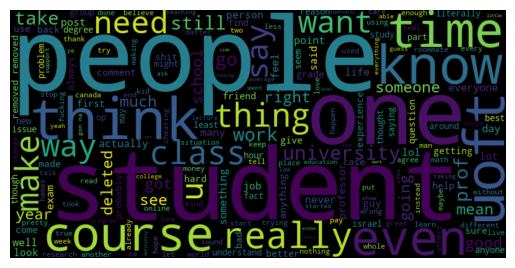

In [109]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt   

wordcloud = WordCloud(width = 800, height = 400).generate(' '.join(all_tokens))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

As it is a university subreddit, people often mention students, uoft, class, people, time. Some more interesting common words include 'deleted' which comes from when reddit users delete their account or comment.

## Topic modeling using LDA

In [120]:
import gensim
from gensim import corpora
from gensim.models import LdaModel

# Create dictioanry
dictionary = corpora.Dictionary(df['lemmatized_tokens'])

# Create corpus
corpus = [dictionary.doc2bow(tokens) for tokens in df['lemmatized_tokens']]

In [118]:
num_topics = 10

lda_model = LdaModel(
    corpus = corpus,
    id2word = dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [119]:
# Print top words per topic
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic #{idx}: {topic}")


Topic #0: 0.015*"student" + 0.009*"university" + 0.007*"get" + 0.007*"like" + 0.006*"one" + 0.006*"uoft" + 0.006*"people" + 0.006*"school" + 0.006*"course" + 0.005*"class"
Topic #1: 0.023*"student" + 0.012*"course" + 0.009*"exam" + 0.008*"like" + 0.008*"would" + 0.007*"prof" + 0.007*"one" + 0.007*"people" + 0.007*"class" + 0.006*"get"
Topic #2: 0.013*"people" + 0.010*"like" + 0.006*"think" + 0.006*"get" + 0.006*"one" + 0.006*"would" + 0.006*"student" + 0.004*"right" + 0.004*"even" + 0.004*"deleted"
Topic #3: 0.016*"removed" + 0.010*"people" + 0.008*"like" + 0.006*"would" + 0.006*"asian" + 0.006*"know" + 0.005*"hell" + 0.005*"money" + 0.005*"get" + 0.005*"time"
Topic #4: 0.009*"israel" + 0.007*"student" + 0.006*"uoft" + 0.006*"like" + 0.006*"week" + 0.006*"hamas" + 0.005*"one" + 0.005*"people" + 0.004*"israeli" + 0.004*"right"
Topic #5: 0.014*"roommate" + 0.011*"people" + 0.009*"like" + 0.007*"guest" + 0.007*"would" + 0.007*"right" + 0.006*"agreement" + 0.006*"comment" + 0.005*"lease" +

In [ ]:
d